# Xây dựng chương trình dự đoán giá nhà trên tập dữ liệu tự định nghĩa

## Bài tập lớn môn học Big Data - BI (CO4033)

GVHD: Đỗ Thaanh Thái

### Sinh viên thực hiện
* Nguyễn Quang Huy - 1916081
* Trần Phúc Anh - 2010133

## Giới thiệu đề tài

Trong bài tập lớn lần này, nhóm em sẽ tự gen data để dự đoán giá nhà dựa trên diện tích, số phòng ngủ, độ tuổi của căn nhà. Bộ dữ liệu gen ra sẽ bao gồm dữ liệu nhiễu và dữ liệu hư hỏng, tiếp sau đó bọn em sẽ thực hiện tiền xử lý dữ liệu trên chính tập dữ liệu đang dùng. Nhóm sẽ gen 2 tập dữ liệu có cấu trúc khác nhau và chuyển đổi về cùng 1 cấu trúc để thực hiện train model.

Tiếp đến, nhóm sẽ thực hiện train dữ liệu trên 3 model chính: 
* Linear Regression
* Decision Tree
* Random Forest
Sau đó, nhóm sẽ so sánh độ hiệu quả giữa 3 mô hình này.

Sau khi so sánh, nhóm sẽ tạo 1 chương trình BI dự đoán giá nhà đất với input từ người dùng bao gồm: diện tích căn nhà, số phòng ngủ và tuổi căn nhà.

Mục đích của BTL lần này theo góc nhìn của nhóm:
* Học được cách xây dựng, tiền xử lý dữ liệu qua kiến thức có được trong môn học
* Làm quen với các model dự đoán dữ liệu phổ biến
* Biết cách xây dựng 1 chương trình BI đơn giản
* Nâng cao kỹ năng sử dụng python

## Cấu trúc notebook
1. Tạo dữ liệu
2. Tiền xử lý dữ liệu
3. Sử dụng mô hình để dự đoán già nhà
4. Xây dựng chương trình BI cho người dùng nhập thông số và dự đoán giá nhà

Link repository của nhóm: https://github.com/huycse31501/BigData_CO4033_HK232




# Tạo dữ liệu

Nhóm sẽ thực hiện gen 2 tập dữ liệu gồm 500000 record với cấu trúc khác nhau.

Đầu tiên nhóm sẽ gen dữ liệu đầu với cấu trúc như sau:
* area: Diện tích căn nhà (đơn vị square feet)
* bedrooms: Số phòng ngủ trong căn nhà
* age: Độ tuổi căn nhà
* price: Giá nhà

### data-generator.py

In [ ]:
import pandas as pd
import numpy as np

np.random.seed(0)

def generate_data(num_samples):
    area = np.random.randint(1000, 5000, num_samples)
    bedrooms = np.random.randint(1, 6, num_samples)
    age = np.random.randint(0, 101, num_samples)


    base_price = 70000
    price = base_price + area * 15 + bedrooms * 8000 - age * 500
    price_noise = np.random.randn(num_samples) * 10000  
    price += price_noise.astype(int)
    
    price[price < 70000] = 70000 + np.abs(price_noise[price < 70000].astype(int))

    data = pd.DataFrame({'area': area, 'bedrooms': bedrooms, 'age': age, 'price': price})

    for col in data.columns:
        data.loc[data.sample(frac=0.05).index, col] = np.nan

    outlier_indices = data.sample(frac=0.01).index
    data.loc[outlier_indices, 'area'] = data.loc[outlier_indices, 'area'] * 1.5
    data.loc[outlier_indices, 'bedrooms'] += 2
    data.loc[outlier_indices, 'age'] = data.loc[outlier_indices, 'age'] * 1.5
    data.loc[outlier_indices, 'price'] = data.loc[outlier_indices, 'price'] * 0.5

    return data

num_samples = 500000
data = generate_data(num_samples)

file_path = 'house-price-data.csv'
data.to_csv(file_path, index=False)

file_path

Trong chương trình trên, nhóm thực hiện gen các cột dữ liệu với những tính chất sau:

Tạo dữ liệu cho cột diện tích (area) từ một phân bố đều hoặc phân bố chuẩn, tuỳ thuộc vào loại bất động sản.
Số lượng phòng ngủ (bedrooms) sẽ phụ thuộc vào diện tích của nhà.

Tuổi của nhà (age) sẽ được tạo ngẫu nhiên nhưng với một số giới hạn hợp lý.

Giá nhà (price) có thể dựa vào một mô hình tuyến tính đơn giản dựa trên diện tích, số phòng ngủ và tuổi của nhà, với một số nhiễu thêm vào.

Lưu ý: Giá nhà nhóm cho giá cơ bản là từ 70.000$ trở lên để tăng tính thực tế

Với tập dữ liệu tiếp theo, nhóm sẽ thay đổi 1 số cột dữ liệu như sau:

* square_feet: Đây là cột biểu diễn diện tích sử dụng của ngôi nhà, tính bằng square feet (feet vuông). Giá trị cho cột này được tạo ra bằng cách sử dụng hàm np.random.randint(900, 4000, num_samples), tạo ra một mảng ngẫu nhiên các số nguyên từ 900 đến 3999, phản ánh phạm vi diện tích hợp lý cho một ngôi nhà.

* bathrooms: Cột này cho biết số lượng phòng tắm trong ngôi nhà. Số liệu trong cột này cũng được sinh ra ngẫu nhiên từ 1 đến 3 bằng hàm np.random.randint(1, 4, num_samples).

* year_built: Năm mà ngôi nhà được xây dựng. Dữ liệu được sinh ngẫu nhiên từ năm 1900 đến năm 2020 thông qua np.random.randint(1900, 2021, num_samples).

* lot_size: Diện tích khu đất mà ngôi nhà đóng trên đó, tính bằng square feet. Các giá trị này được tạo ra ngẫu nhiên trong khoảng từ 1000 đến 9999 square feet bằng hàm np.random.randint(1000, 10000, num_samples).

* price: Giá của ngôi nhà, được tính toán dựa trên một công thức giả định có liên quan đến diện tích sử dụng, số phòng tắm, tuổi của ngôi nhà và thêm vào một số nhiễu. Giá cơ bản bắt đầu từ 70000

### alternative-data-generator.py



In [ ]:

import pandas as pd
import numpy as np

def generate_alternative_data(num_samples):
    square_feet = np.random.randint(900, 4000, num_samples)
    bathrooms = np.random.randint(1, 4, num_samples)
    year_built = np.random.randint(1900, 2021, num_samples)
    lot_size = np.random.randint(1000, 10000, num_samples)
    

    base_price = 70000
    price = base_price + square_feet * 15 + bathrooms * 16000 - year_built * 500
    price_noise = np.random.randn(num_samples) * 10000  
    price += price_noise.astype(int)
    
    price[price < 70000] = 70000 + np.abs(price_noise[price < 70000].astype(int))
    
    new_data = pd.DataFrame({
        'square_feet': square_feet,
        'bathrooms': bathrooms,
        'year_built': year_built,
        'lot_size': lot_size,
        'price': price
    })
    
    for col in new_data.columns:
        new_data.loc[new_data.sample(frac=0.05).index, col] = np.nan
    
    outlier_indices = new_data.sample(frac=0.01).index
    new_data.loc[outlier_indices, 'square_feet'] *= 1.2
    new_data.loc[outlier_indices, 'bathrooms'] += 1
    new_data.loc[outlier_indices, 'year_built'] -= 10
    new_data.loc[outlier_indices, 'lot_size'] *= 1.1
    new_data.loc[outlier_indices, 'price'] *= 0.7
    
    return new_data

num_samples = 500000
new_data = generate_alternative_data(num_samples)

alternative_file_path = 'alternative-house-price-data.csv'
new_data.to_csv(alternative_file_path, index=False)

alternative_file_path

## Hỉnh ảnh minh họa của 2 tệp dữ liệu được gen ra

### house-price-data.csv
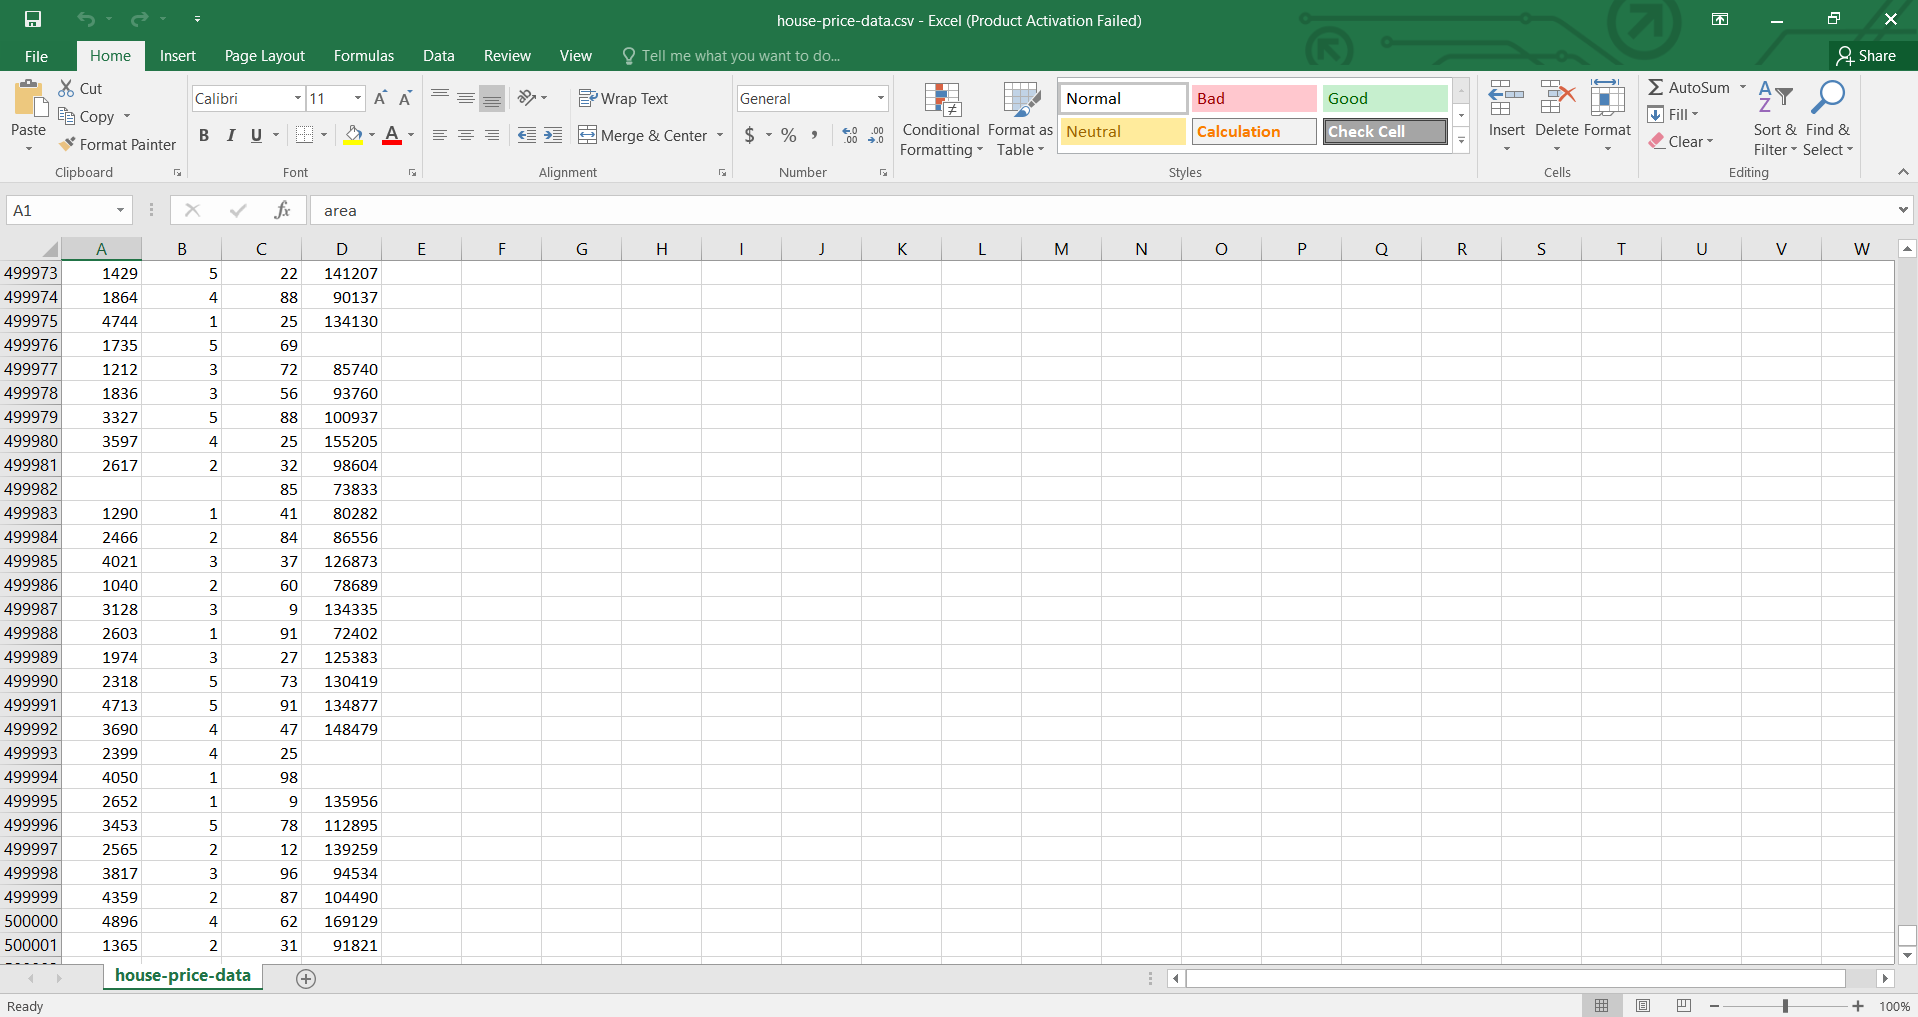

### alternative-house-price-data.csv
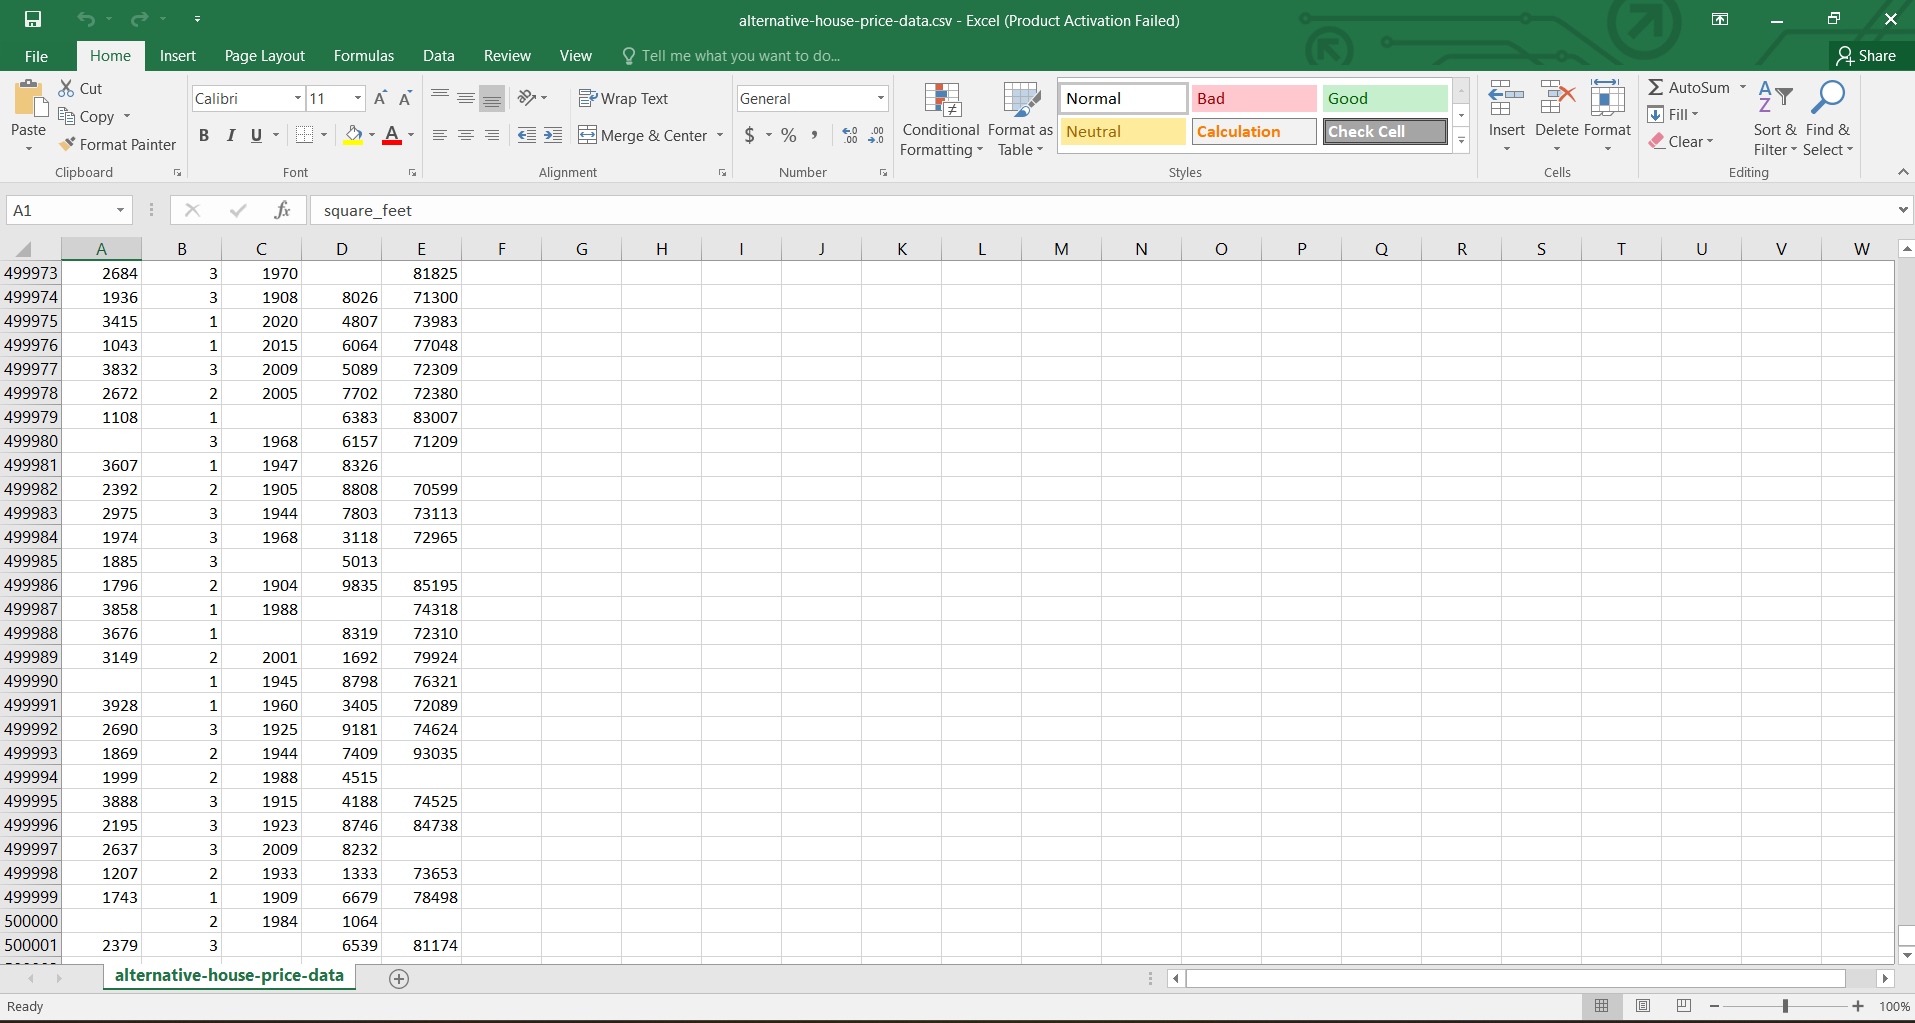

# Tiền xử lý dữ liệu

Để xử lý dữ liệu, đầu tiên nhóm sẽ loại bỏ những dữ liệu trống hoặc hỏng (NA)

In [ ]:
data_cleaned = data.dropna()

Sau đó, nhóm thực hiện sửa chữa dữ liệu sai định dạng hoặc không hợp lệ:

In [ ]:
for col in data.columns:
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='coerce')

Cuối cùng, nhóm loại bỏ những dữ liệu nhiễu như outliers

In [ ]:
Q1 = data_cleaned.quantile(0.25)
Q3 = data_cleaned.quantile(0.75)
IQR = Q3 - Q1

data_no_outliers = data_cleaned[~((data_cleaned < (Q1 - 1.5 * IQR)) | (data_cleaned > (Q3 + 1.5 * IQR))).any(axis=1)]

Đối với tập dữ liệu không cùng cấu trúc ở file số 2, nhóm sẽ thực hiện 1 số transformation để ép về cấu trúc như ban đầu:

In [ ]:
transformed_data = new_data.copy()
transformed_data['area'] = transformed_data['square_feet']
transformed_data['bedrooms'] = transformed_data['bathrooms'] * 2
transformed_data['age'] = 2024 - transformed_data['year_built']

transformed_data.drop(['square_feet', 'bathrooms', 'year_built', 'lot_size'], axis=1, inplace=True)

data = transformed_data

Cuối cùng đây là 2 chương trình để xử lý dữ liệu của nhóm

### data-preprocessing.py

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv('house-price-data.csv')


data_cleaned = data.dropna()
for col in data.columns:
    data_cleaned.loc[:, col] = pd.to_numeric(data_cleaned.loc[:, col], errors='coerce')

data_cleaned = data_cleaned.dropna()

Q1 = data_cleaned.quantile(0.25)
Q3 = data_cleaned.quantile(0.75)
IQR = Q3 - Q1

data_no_outliers = data_cleaned[~((data_cleaned < (Q1 - 1.5 * IQR)) | (data_cleaned > (Q3 + 1.5 * IQR))).any(axis=1)]

if data_no_outliers.isnull().any().any():
        data.dropna(inplace=True)

if data_no_outliers.isnull().values.any():
    data_no_outliers.dropna(inplace=True)


data_normalized = pd.DataFrame(data_no_outliers, columns=data_no_outliers.columns)

file_path = 'transformed-alternative-data.csv'
data_normalized.to_csv(file_path, index=False)


### data-preprocessing-alternative.py

In [ ]:


import pandas as pd
from sklearn.preprocessing import MinMaxScaler

new_data = pd.read_csv('alternative-house-price-data.csv')

transformed_data = new_data.copy()
transformed_data['area'] = transformed_data['square_feet']
transformed_data['bedrooms'] = transformed_data['bathrooms'] * 2
transformed_data['age'] = 2024 - transformed_data['year_built']

transformed_data.drop(['square_feet', 'bathrooms', 'year_built', 'lot_size'], axis=1, inplace=True)

data = transformed_data
data_cleaned = data.dropna()
for col in data.columns:
    data_cleaned.loc[:, col] = pd.to_numeric(data_cleaned.loc[:, col], errors='coerce')

data_cleaned = data_cleaned.dropna()

Q1 = data_cleaned.quantile(0.25)
Q3 = data_cleaned.quantile(0.75)
IQR = Q3 - Q1

data_no_outliers = data_cleaned[~((data_cleaned < (Q1 - 1.5 * IQR)) | (data_cleaned > (Q3 + 1.5 * IQR))).any(axis=1)]


if data_no_outliers.isnull().any().any():
        data.dropna(inplace=True)

if data_no_outliers.isnull().values.any():
    data_no_outliers.dropna(inplace=True)

data_normalized = pd.DataFrame(data_no_outliers, columns=data_no_outliers.columns)

file_path = 'house-price-data-after-preprocessing.csv'
data_normalized.to_csv(file_path, index=False)
print(data_normalized.head(10))

# Sử dụng và đánh giá những mô hình để dự đoán giá nhà

Những mô hình mà nhóm sử dụng sẽ bao gồm: 
* Linear Regression
* Decision Tree
* Random Forest

Lưu ý rằng, trong mô hình Random Forest nhóm sẽ để n_estimators là 100 để số lượng cây là 100 cây trong rừng

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100)
}

Nhóm sẽ thực hiện chia dữ liệu thành 2 tập là tập huấn luyện và tập kiểm tra, với 20% dữ liệu cho việc kiểm tra, và số còn lại dùng để huấn luyện. random_state=42 đảm bảo rằng mỗi lần chạy code, việc chia dữ liệu sẽ giống nhau.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Đây là toàn bộ đoạn code nhóm sử dụng để xây mô hình dự đoán và so sánh kết quả

### house-price-predictor.py

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, root_mean_squared_error

data1 = pd.read_csv('transformed-alternative-data.csv')
data2 = pd.read_csv('house-price-data-after-preprocessing.csv')

data = pd.concat([data1, data2])

X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(f"{name}:")
    print(f"R^2: {r2_score(y_test, predictions):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, predictions):.4f}")
    print(f"RMSE: {root_mean_squared_error(y_test, predictions):.4f}\n")

Đây là kết quả so sánh giữa 3 mô hình:

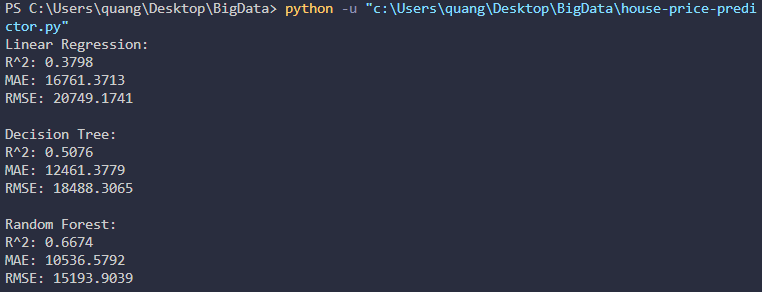

Các thông số trên có ý nghĩa như sau:
* R^2 (R-squared): Đo lường mức độ mà các biến độc lập giải thích được biến phụ thuộc - Giá trị này càng gần 1 càng tốt.
* MAE (Mean Absolute Error): Trung bình giá trị tuyệt đối của các sai số giữa các dự đoán và giá trị thực tế - Giá trị này càng nhỏ càng tốt.
* RMSE (Root Mean Squared Error): Căn bậc hai của trung bình giá trị bình phương của các sai số -  Giá trị này càng nhỏ càng tốt

Có thể thấy, so với các record có giá nhà đều từ 70.000$ trở lên, việc lệch khoảng tầm 10.000$ là ở mức độ tạm chấp nhận được, vì vậy mô hình Random Forest đưa ra hiệu suất tốt nhất

# Xây dựng chương trình BI cho người dùng nhập thông số và dự đoán giá nhà

### house-price-BI.py

In [ ]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, root_mean_squared_error

def train_and_save_models(data1_path, data2_path):
    data1 = pd.read_csv(data1_path)
    data2 = pd.read_csv(data2_path)
    data = pd.concat([data1, data2])

    X = data.drop('price', axis=1)
    y = data['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(n_estimators=100)
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        joblib.dump(model, f'model_{name.replace(" ", "_")}.joblib')

def get_user_input():
    area = float(input("Nhập diện tích ngôi nhà (tính bằng feet vuông): "))
    bedrooms = int(input("Nhập số lượng phòng ngủ: "))
    age = int(input("Nhập tuổi của ngôi nhà (tính bằng năm): "))
    return area, bedrooms, age

def predict_price(model_choice, area, bedrooms, age):
    models = {
        '1': 'Linear Regression',
        '2': 'Decision Tree',
        '3': 'Random Forest'
    }
    model_name = models.get(model_choice)
    if model_name is None:
        print("Lựa chọn không hợp lệ.")
        return None
    model = joblib.load(f'model_{model_name.replace(" ", "_")}.joblib')
    user_data = pd.DataFrame([[area, bedrooms, age]], columns=['area', 'bedrooms', 'age'])
    predicted_price = model.predict(user_data)
    return predicted_price[0]

def main():
    train_and_save_models('transformed-alternative-data.csv', 'house-price-data-after-preprocessing.csv')

    print("Vui lòng nhập thông tin chi tiết của ngôi nhà:")
    area, bedrooms, age = get_user_input()

    model_choice = input("Chọn mô hình để sử dụng (1 - Hồi quy tuyến tính, 2 - Cây quyết định, 3 - Rừng ngẫu nhiên): ")
    price_prediction = predict_price(model_choice, area, bedrooms, age)
    if price_prediction is not None:
        print(f"Giá nhà ước lượng là: ${price_prediction:.2f}")

if __name__ == "__main__":
    main()

Lưu ý: nếu chạy lần đầu, ta có thể để dòng code 

train_and_save_models('transformed-alternative-data.csv', 'house-price-data-after-preprocessing.csv')

ở hàm main. Tuy nhiên, từ những lần chạy sau, ta có thể comment dòng này lại vì lúc này ta đã có sẵn job cho nó, không cần khởi tạo lại

Một số hình ảnh khi chạy chương trình:

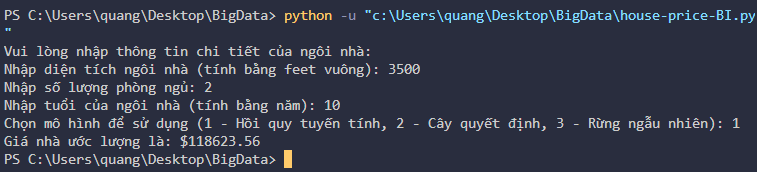

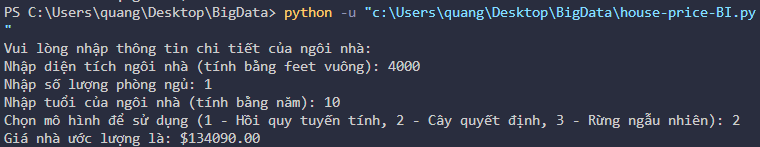

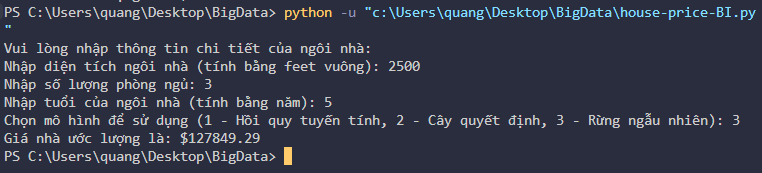


# Kết luận

Tuy kết quả trong bài tập lần này sẽ không mang tính ứng dụng quá nhiều, nhưng trong quá trình thực hiện - các thành viên trong nhóm đã học được và cải thiện thêm rất nhiều kỹ năng và kiến thức cho bản thân. Nhóm em mong rằng, sau bài tập lần này, các thành viên trong nhóm sẽ có thêm góc nhìn về hướng Big Data - BI. Từ đó, quyết định lối đi cho bản thân trong tương lai
